In [541]:
import numpy as np
from gmr import GMM, plot_error_ellipses
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import os

element = "U-238_14"
data = pd.read_csv(f"../Data/Mass_Yields/{element}.csv")
X = data["A"]
Z = data["Z"]
E = data["E"]
N = data["N"]
data = data.drop(columns = ['Z', 'E', 'N']) 

# aic values and model creation

In [542]:
components_range = range(1, 13)

# Initialize variables to store AIC values and GMM models
aic_values = []
gmm_models = []

# Iterate over different numbers of components
for n_components in components_range:
    # Create and fit GMM
    gmm_sklearn = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    gmm_sklearn.fit(data)
    
    # Store AIC value and model
    aic_values.append(gmm_sklearn.aic(data))
    gmm_models.append(gmm_sklearn)

# Find the index of the minimum AIC value
best_index = np.argmin(aic_values)

# Retrieve the best GMM model and its number of components
best_gmm = gmm_models[best_index]
best_n_components = components_range[best_index]

# Use the best GMM model for further analysis
best_gmm.fit(data)
X_tested1, _ = best_gmm.sample(10000)
X_tested = np.array(X_tested1[:,0])
covariances = best_gmm.covariances_
regularization_value = 1e-12
regularized_covariances = [cov + regularization_value * np.eye(cov.shape[0]) for cov in covariances]
gmm = GMM(
    n_components=best_n_components, priors=best_gmm.weights_, means=best_gmm.means_,
    covariances=regularized_covariances)


In [543]:
X_sampled = gmm.from_samples(data)
X = np.linspace(X.min(), X.max(), 10000)
Y_means = gmm.predict(np.array([0]), X[:, np.newaxis])

In [544]:
print("data:     ",data.shape)
print("X:        ",X.shape)
print("X_tested: ",X_tested.shape)
print("Y_means:  ",Y_means.shape)

data:      (49, 2)
X:         (10000,)
X_tested:  (10000,)
Y_means:   (10000, 1)


# GMR Plotting

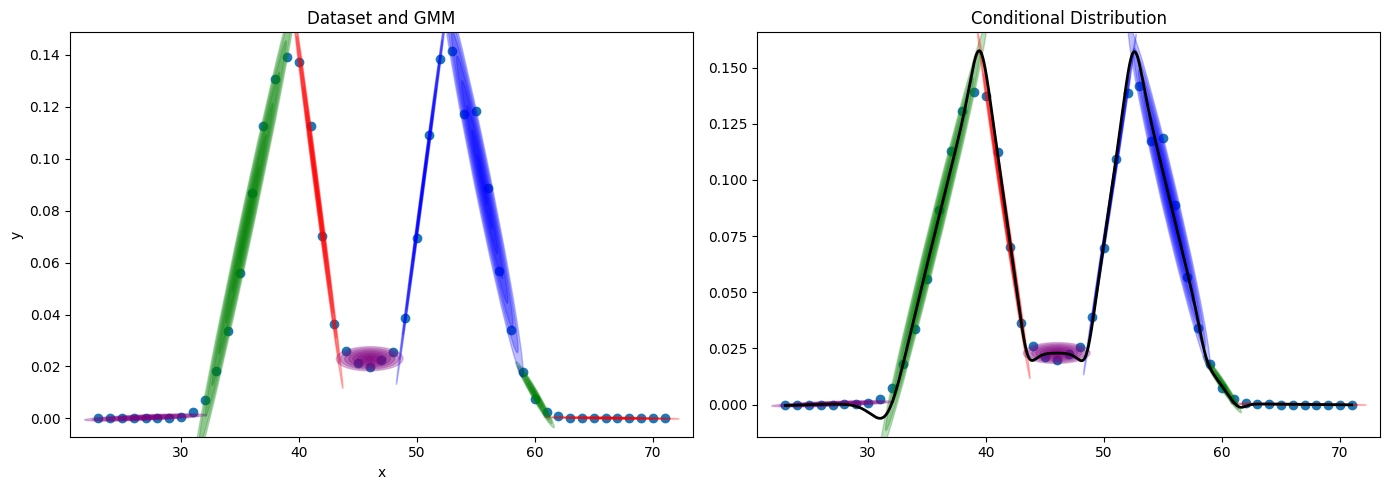

In [545]:
plt.figure(figsize=(14, 5))

ax = plt.subplot(121)
ax.set_title("Dataset and GMM")
ax.scatter(data["Z"], data["Fission Yield"])
colors = ["r", "g", "b", "purple"]
plot_error_ellipses(ax, gmm, colors=colors)
ax.set_xlabel("Mass Number (A)")
ax.set_ylabel("Fission Yield")

ax = plt.subplot(122)
ax.set_title("Conditional Distribution")
ax.scatter(data["A"], data["Fission Yield"])
plot_error_ellipses(plt.gca(), gmm, colors=colors)
plt.plot(X, Y_means.ravel(), c="k", lw=2)
plt.tight_layout()
#plt.savefig("GMR.png",dpi=300)
plt.show()

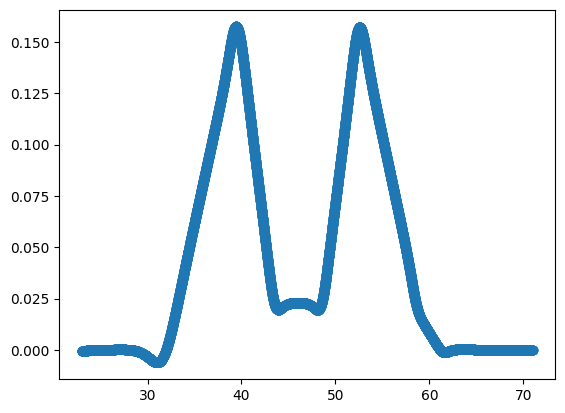

In [546]:
samples_GPR = np.column_stack((X, Y_means))
df = pd.DataFrame(samples_GPR, columns=['A', 'Fission Yield'])
df['Z'] = Z.iloc[0]
df['E'] = E.iloc[0]
df['N'] = N.iloc[0]
os.makedirs('GMR_Samples', exist_ok=True)
df.to_csv(os.path.join('GMR_Samples', fr'{element}_GMR.csv'), index=False)
plt.scatter(X, Y_means)